In [1]:
#------------------------------------------------------------------------------------
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.tools import make_default_context
import matplotlib as matplotlib
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D


#-------------------------------------------------------------------------------------
from pywignercuda_path import SetPyWignerCUDA_Path
SetPyWignerCUDA_Path()
from GPU_Dirac3D import *


In [2]:
#import pyqtgraph as pg

In [3]:
%matplotlib inline

In [4]:
class DefinePotential_Dirac3D( GPU_Dirac3D ):
    def __init__ (self):
        #....................Defining the geometry.....................................    
        gridDIM_X = 256
        gridDIM_Y = 256
        gridDIM_Z = 256
        
        X_amplitude =10
        Y_amplitude =10
        Z_amplitude =10
        
        dt = 0.01

        timeSteps =  1000
        skipFrames =  500
        #...................Defining the kinematic-dynamical constants.................
        self.mass = 1.
        self.c = 1.
        self.hBar = 1.
        #...................Defining the potential and initial state parameters........
        hBar = 1
    
        self.px = 0.
        self.py = 0.
        self.pz = 0.
        
        self.energy = self.c*np.sqrt( (self.mass*self.c)**2 +  self.px**2 + self.py**2 + self.pz**2  )
        #...................Defining the potential.....................................
       
        omega = 1.
        
        self.Potential_0_String = '0.'
        
        self.Potential_1_String = \
        '-sin({omega}*(t-z))/({omega}*dt)  +  sin( {omega}*(t-z) + dt*{omega} )/({omega}*dt) '.format(omega=omega)
        
        self.Potential_2_String = \
        'cos({omega}*(t-z))/({omega}*dt)  -  cos( {omega}*(t-z) + dt*{omega} )/({omega}*dt) '.format(omega=omega)
        
        #self.Potential_1_String = 'cos({omega}*(t-z))'.format(omega=omega)
        
        #self.Potential_2_String = 'sin({omega}*(t-z))'.format(omega=omega)
        
        self.Potential_3_String = '0.'
        
        #..................Defining the output directory/file .........................
        self.fileName =  '/home/rcabrera/DATA/Dirac3D/Volkov.hdf5'

        self.Compute_Ehrenfest_P = True
        #..............................................................................	

        amplitude = (X_amplitude,Y_amplitude,Z_amplitude)
        gridDIM   = (gridDIM_X,gridDIM_Y,gridDIM_Z)
        
        GPU_Dirac3D.__init__( self,gridDIM, amplitude ,dt,timeSteps, skipFrames = skipFrames,frameSaveMode='Spinor')

        
    def Set_Initial_Condition_SpinUp (self):

        def gaussian(x,y,z):
            return np.exp( - ( (x)**2 + y**2 + (z+6)**2)/4. )
        
        self.Psi_init = self.Spinor_Particle_SpinUp(  (self.px,self.py,self.pz) , gaussian )
        
        #norm = self.Norm_X_CPU( self.Psi_init )
        norm = self.Norm( self.Psi_init )
        
        self.FilterElectrons(1) 
        
        self.Psi_init /= norm  
        
        
    def Set_Initial_Condition_SpinDown (self):

        def gaussian(x,y,z):
            return np.exp( - ( x**2 + y**2 + (z+6)**2)/4. )
        
        self.Psi_init = self.Spinor_Particle_SpinDown(  (self.px,self.py,self.pz) , gaussian )
        
        #norm = self.Norm_X_CPU( self.Psi_init )
        self.FilterElectrons(1)
        norm = self.Norm( self.Psi_init )
        
        self.Psi_init /= norm  
        
    def Set_Initial_Condition (self):

        def gaussian(x,y,z):
            return np.exp( - ( (x)**2 + y**2 + (z+2)**2)/8. )
                
        self.Psi_init = np.array([
                 1. *gaussian( self.X, self.Y, self.Z ) * np.exp(  1j*0.5*self.Z ),
                0.5 *gaussian( self.X, self.Y, self.Z ) * np.exp( -1j*0.5*self.Z ),
                 0. *gaussian( self.X, self.Y, self.Z )  ,
               -0.5 *gaussian( self.X, self.Y, self.Z ) * np.exp( -1j*0.5*self.Z )
                               ])
        
        #norm = self.Norm_X_CPU( self.Psi_init )
        norm = self.Norm( self.Psi_init )
        
        #self.FilterElectrons(1) 
        
        self.Psi_init /= norm 

In [5]:
instance = DefinePotential_Dirac3D()

In [6]:
instance = DefinePotential_Dirac3D()

instance.Set_Initial_Condition()

#instance_Dirac3D.FilterElectrons(1)

print '                                      '
print ' dx = ', instance.dX

Psi_end = instance.Run ()

                                      
 dx =  0.078125
--------------------------------------------
              Dirac Propagator 3D           
--------------------------------------------
  save Mode  =   Spinor
         GPU memory Total        5.24945068359 GB
         GPU memory Free         1.99719619751 GB
                                                               
number of steps  =   1000  dt =  0.01
dX =  0.078125 dY =  0.078125 dZ =  0.078125
dPx =  0.314159265359 dPy =  0.314159265359 dPz =  0.314159265359
                                                               
  
 progress  0 %
 norm step 1 =  33029.3259969
 progress  49 %
 progress  99 %
 computational time  =  773.173724174


In [7]:
print 'norm = ',instance.Norm( instance.Psi_end )

norm =  1.0


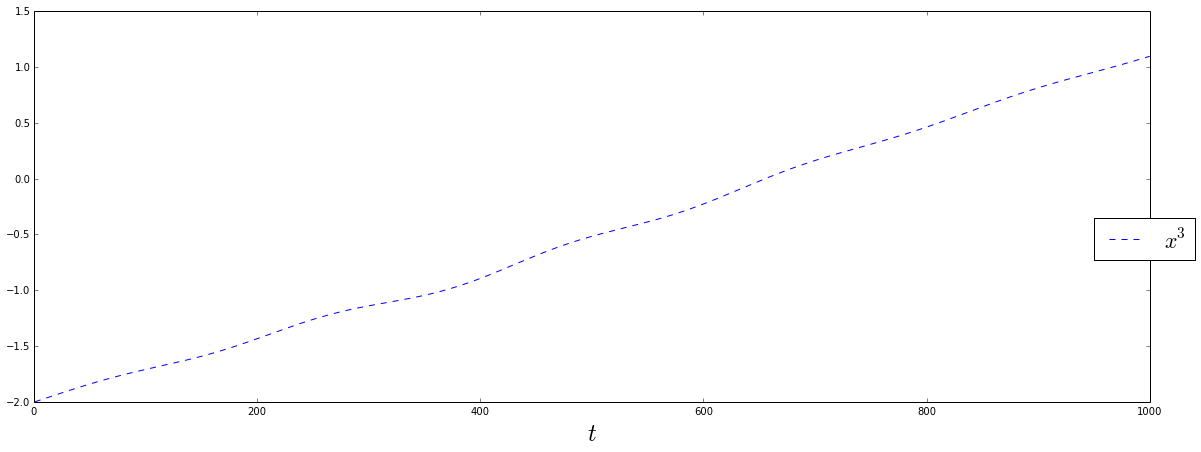

In [8]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))

ax.plot( instance.timeRange ,  instance.Z_average   , 'b--',label= '$x^3 $')

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

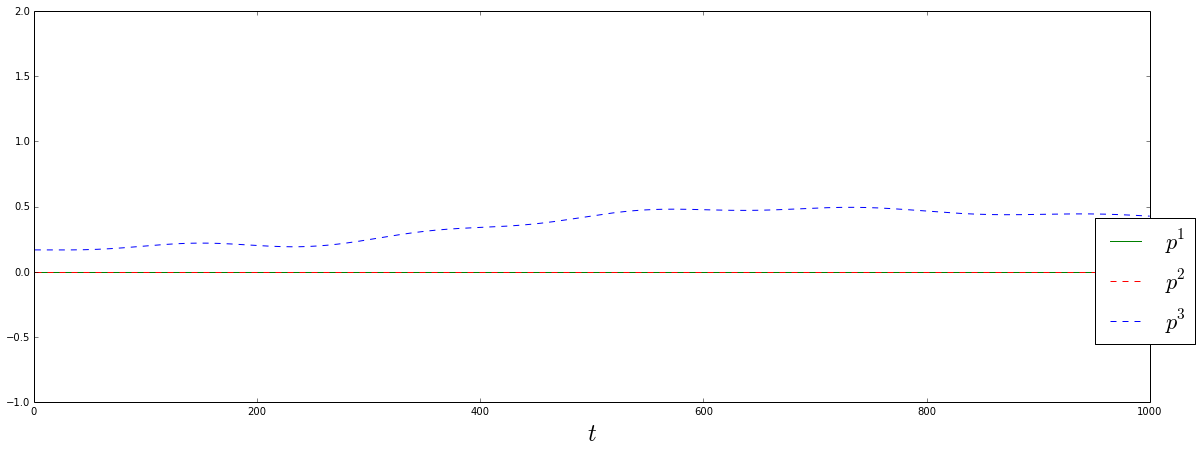

In [9]:
if instance.Compute_Ehrenfest_P == True:
    axis_font = {'size':'24'}
    
    fig, ax = plt.subplots(figsize=(20, 7))
    
    ax.plot( instance.timeRange ,  instance.Px_average   , 'g',label= '$p^1 $')
    
    ax.plot( instance.timeRange ,  instance.Py_average   , 'r--',label= '$p^2 $')
    
    ax.plot( instance.timeRange ,  instance.Pz_average   , 'b--',label= '$p^3 $')
    
    ax.set_ylim(-1,2)
    
    ax.set_xlabel(r'$t$',**axis_font)
    
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

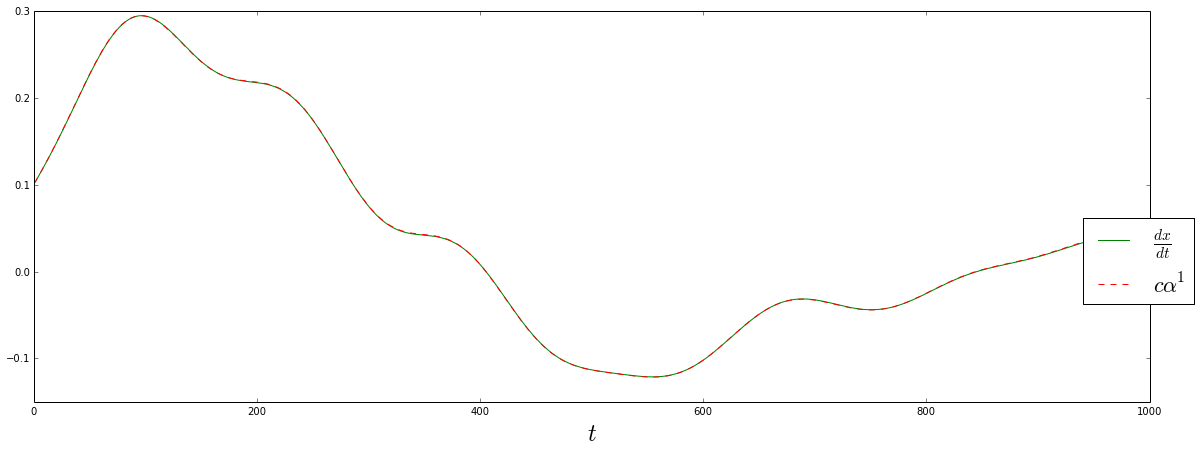

In [10]:
axis_font = {'size':'24'}


fig, ax = plt.subplots(figsize=(20, 7))

ax.plot( instance.timeRange ,  np.gradient( instance.X_average , instance.dt)  , 'g',
        label= '$\\frac{dx}{dt} $')

ax.plot( instance.timeRange ,  instance.Alpha1_average ,'r--' ,label='$c \\alpha^1$')

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

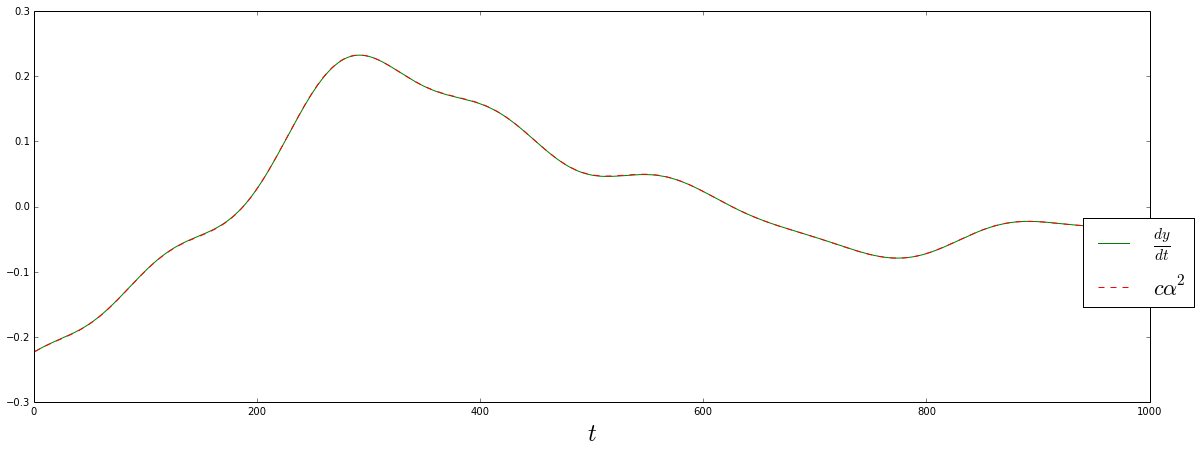

In [11]:
axis_font = {'size':'24'}


fig, ax = plt.subplots(figsize=(20, 7))

ax.plot( instance.timeRange ,  np.gradient( instance.Y_average , instance.dt)  , 'g',
        label= '$\\frac{dy}{dt} $')

ax.plot( instance.timeRange ,  instance.Alpha2_average ,'r--' ,label='$c \\alpha^2$')

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

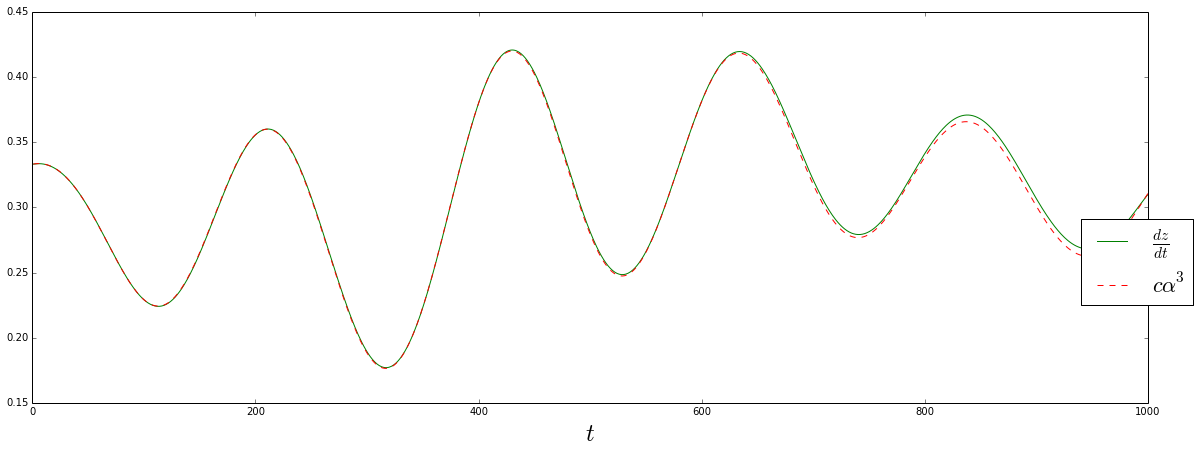

In [12]:
axis_font = {'size':'24'}


fig, ax = plt.subplots(figsize=(20, 7))

ax.plot( instance.timeRange ,  np.gradient( instance.Z_average , instance.dt)  , 'g',
        label= '$\\frac{dz}{dt} $')

ax.plot( instance.timeRange ,  instance.Alpha3_average ,'r--' ,label='$c \\alpha^3$')

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

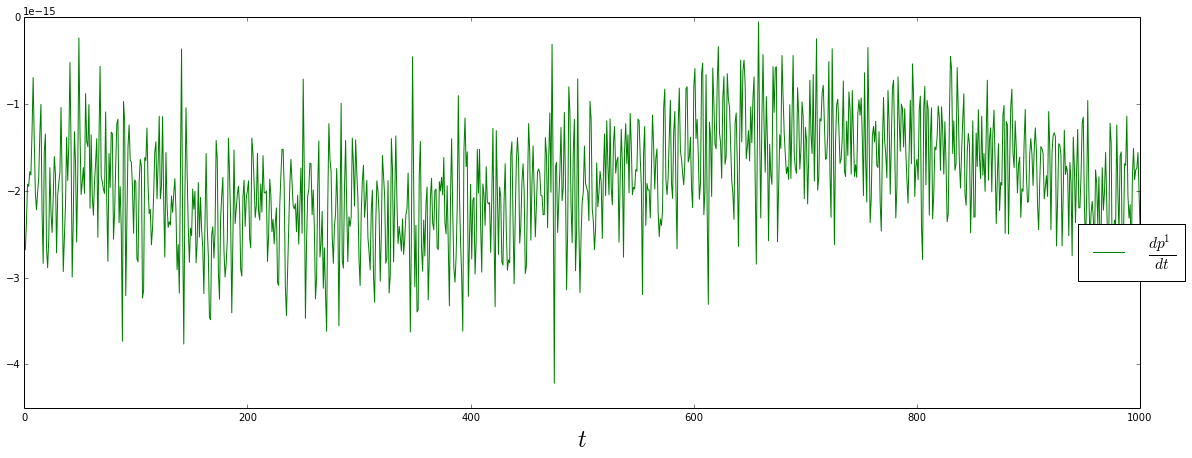

In [13]:
if instance.Compute_Ehrenfest_P == True:
    
    axis_font = {'size':'24'}
    
    fig, ax = plt.subplots(figsize=(20, 7))
    
    ax.plot( instance.timeRange ,  np.gradient( instance.Px_average , instance.dt)  , 'g',
            label= '$\\frac{dp^1}{dt} $')
    
    
    ax.set_xlabel(r'$t$',**axis_font)
    
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

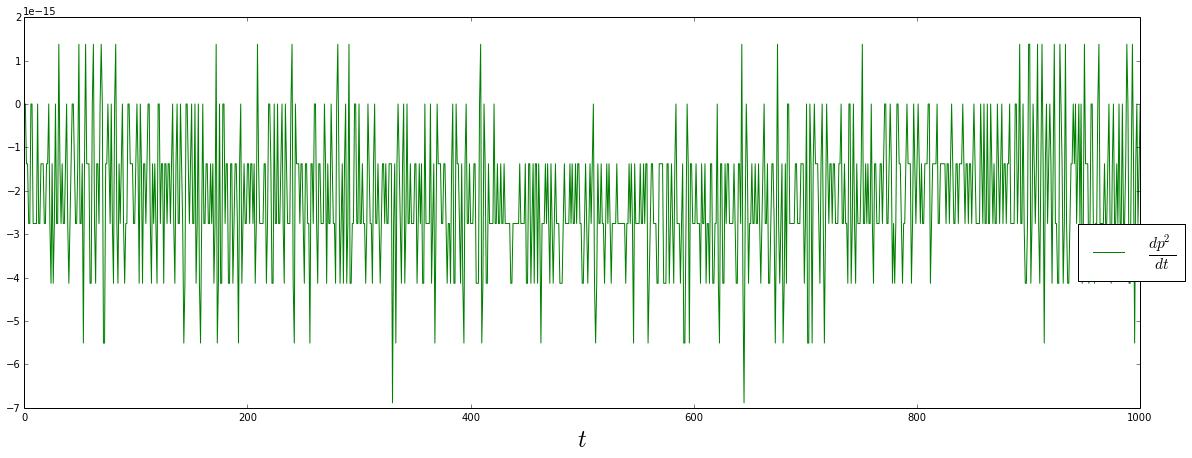

In [14]:
if instance.Compute_Ehrenfest_P == True:
    
    axis_font = {'size':'24'}
    
    fig, ax = plt.subplots(figsize=(20, 7))
    
    ax.plot( instance.timeRange ,  np.gradient( instance.Py_average , instance.dt)  , 'g',
            label= '$\\frac{dp^2}{dt} $')
    
    
    ax.set_xlabel(r'$t$',**axis_font)
    
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

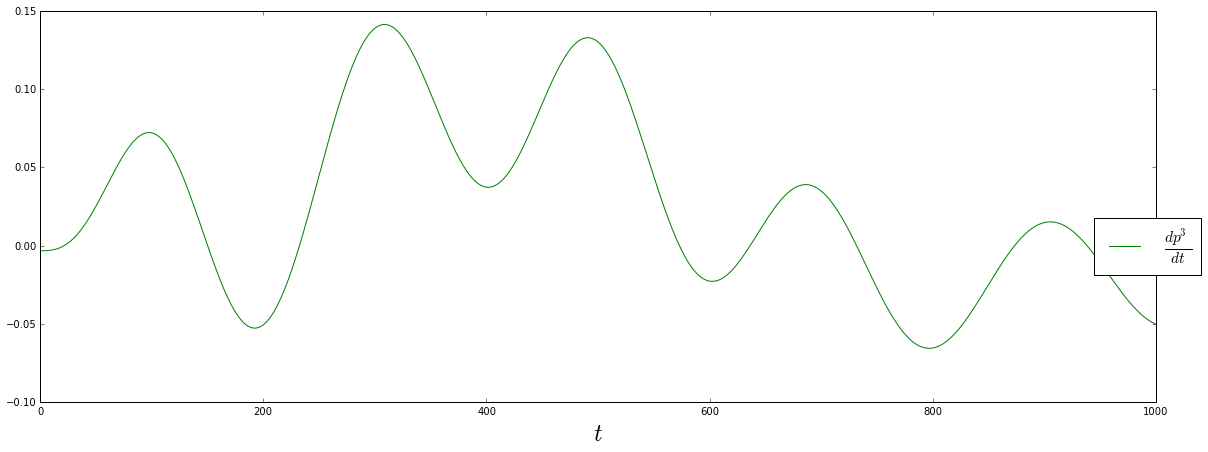

In [15]:
if instance.Compute_Ehrenfest_P == True:
    
    axis_font = {'size':'24'}
    
    fig, ax = plt.subplots(figsize=(20, 7))
    
    ax.plot( instance.timeRange ,  np.gradient( instance.Pz_average , instance.dt)  , 'g',
            label= '$\\frac{dp^3}{dt} $')
    
    
    ax.set_xlabel(r'$t$',**axis_font)
    
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

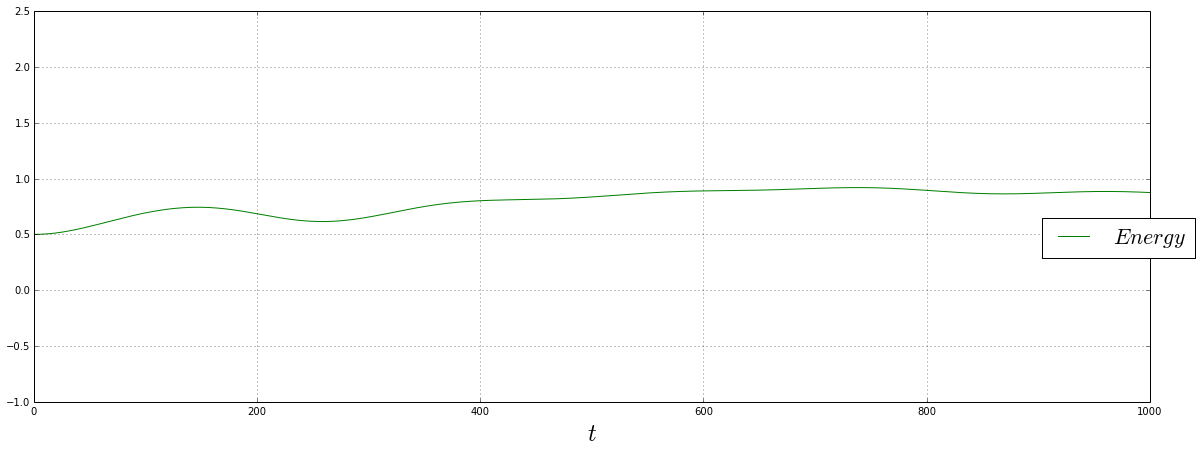

In [16]:
if instance.Compute_Ehrenfest_P == True:
    
    axis_font = {'size':'24'}
    
    fig, ax = plt.subplots(figsize=(20, 7))
    
    ax.plot( instance.timeRange ,  instance.K_Energy_average + instance.Potential_0_average , 'g',
            label= '$ Energy$')
    
    ax.set_ylim(-1,2.5)
    
    ax.set_xlabel(r'$t$',**axis_font)
    
    ax.grid('on')
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

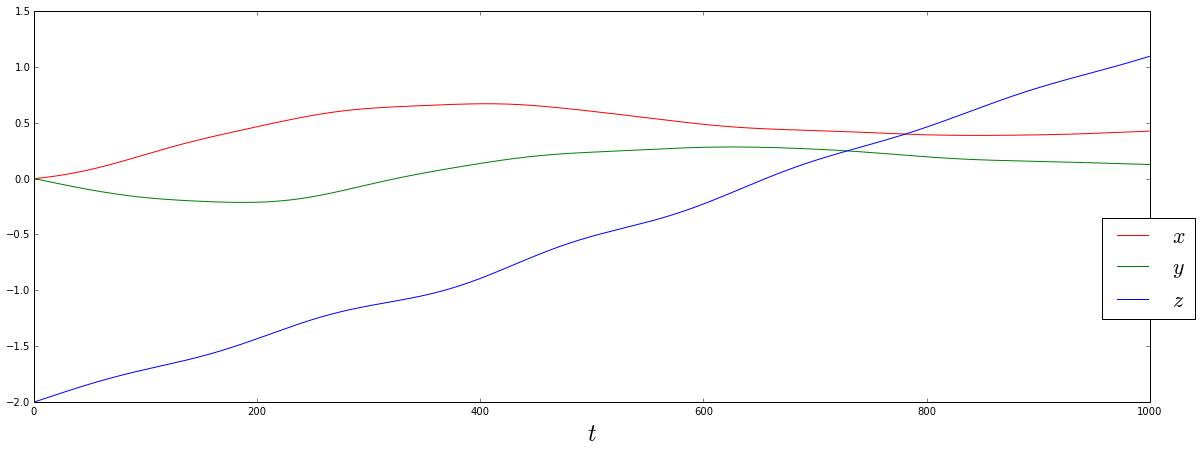

In [17]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))

ax.plot( instance.timeRange ,  instance.X_average  ,'r-' ,label='$x$')
ax.plot( instance.timeRange ,  instance.Y_average  ,'g-' ,label='$y$')
ax.plot( instance.timeRange ,  instance.Z_average  ,'b-' ,label='$z$')

ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

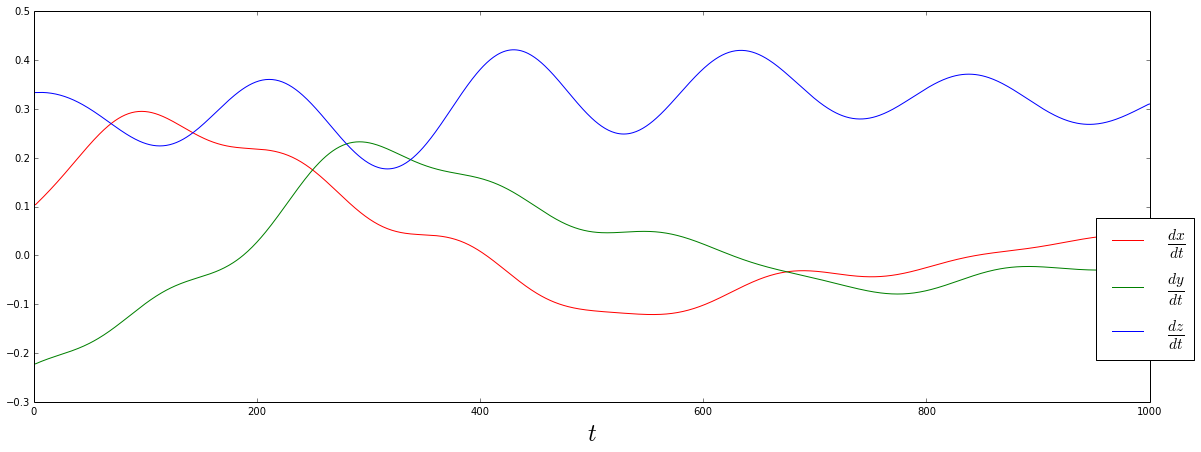

In [18]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))

ax.plot( instance.timeRange ,  np.gradient( instance.X_average , instance.dt)  ,'r-' ,label='$\\frac{dx}{dt} $' ) 
ax.plot( instance.timeRange ,  np.gradient( instance.Y_average , instance.dt)  ,'g-' ,label='$\\frac{dy}{dt} $' ) 
ax.plot( instance.timeRange ,  np.gradient( instance.Z_average , instance.dt)  ,'b-' ,label='$\\frac{dz}{dt} $' ) 


ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

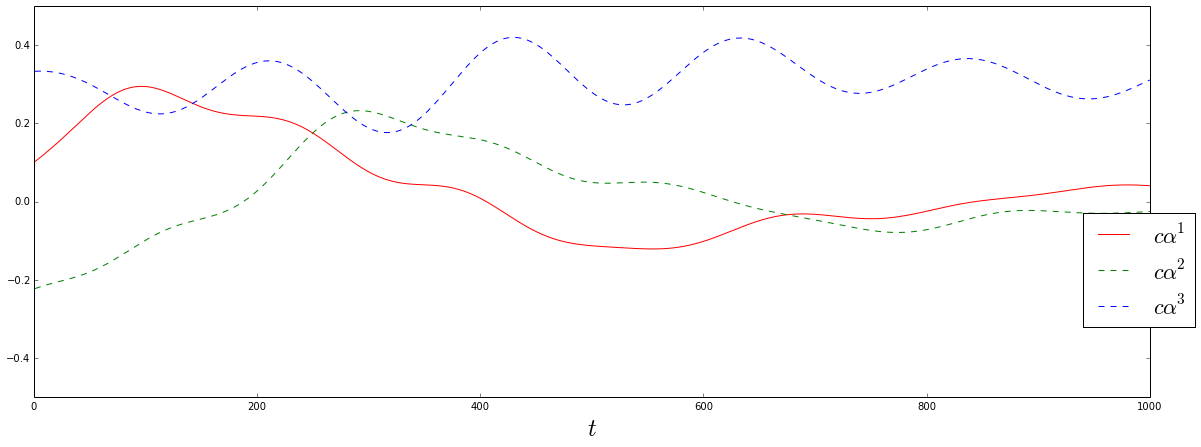

In [19]:
axis_font = {'size':'24'}

fig, ax = plt.subplots(figsize=(20, 7))

ax.plot( instance.timeRange ,  instance.Alpha1_average ,'r-' ,label='$c \\alpha^1$')

ax.plot( instance.timeRange ,  instance.Alpha2_average ,'g--' ,label='$c \\alpha^2$')

ax.plot( instance.timeRange ,  instance.Alpha3_average ,'b--' ,label='$c \\alpha^3$')

ax.set_ylim(-0.5,0.5)
ax.set_xlabel(r'$t$',**axis_font)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=1, prop={'size':22})

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


(-5, 0)

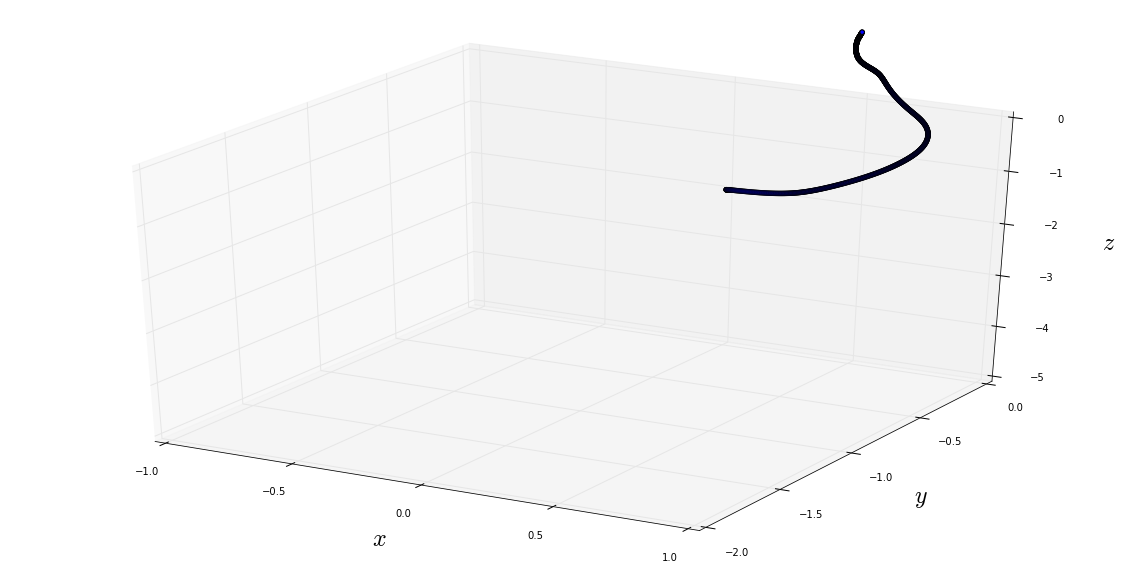

In [20]:

fig, ax = plt.subplots(figsize=(20, 10))


ax = fig.gca(projection='3d')

ax.scatter(
            instance.X_average,
            instance.Y_average,
            instance.Z_average
            )

ax.set_xlabel(r'$x$',**axis_font)

ax.set_ylabel(r'$y$',**axis_font)

ax.set_zlabel(r'$z$',**axis_font)

ax.set_xlim(-1 ,1)
ax.set_ylim(-2,0)
ax.set_zlim(-5,0)

(-1, 1)

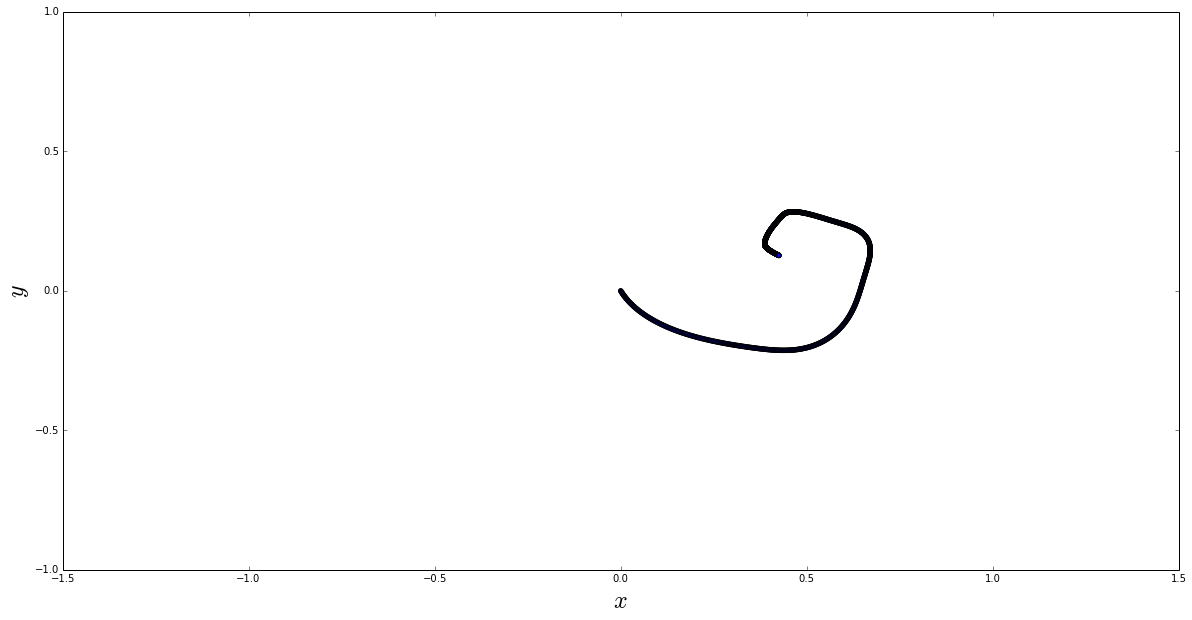

In [21]:

fig, ax = plt.subplots(figsize=(20, 10))


#ax = fig.gca(projection='3d')

ax.scatter(
            instance.X_average,
            instance.Y_average            )

ax.set_xlabel(r'$x$',**axis_font)

ax.set_ylabel(r'$y$',**axis_font)

ax.set_xlim(-1.5 ,1.5)
ax.set_ylim(-1   ,1)
#ax.set_zlim(-5,0)